## 1\. Contexto

### **1.1.  Loggi**

[<img src="https://logodownload.org/wp-content/uploads/2019/07/loggi-logo-1.png" width="250"/>](image.png)

A [Loggi](https://www.loggi.com/) é uma startup unicórnio brasileira de tecnologia focada em **logística**. A Loggi começou entregando apenas documentos entre 2013 e 2014. Dois anos depois, entrou no segmento de e-commerce. E, desde 2017, tem atuado nas entregas de alimentos também.

### **1.2.  Loggi BUD**

O Loggi Benchmark for Urban Deliveries (BUD) é um repositório do GitHub ([link](https://github.com/loggi/loggibud)) com dados e códigos para problemas típicos que empresas de logística enfrentam: otimização das rotas de entrega, alocação de entregas nos veículos da frota com capacidade limitada, etc. Os dados são sintetizados de fontes públicas (IBGE, IPEA, etc.) e são representativos dos desafios que a startup enfrenta no dia a dia, especialmente com relação a sua escala.

### **1.3. Dados**

O conjunto de dados simula o desafio de uma grande empresa de entregas na etapa de última milha da cadeia de suprimentos. Na primeira versão fornecida, há 90 instâncias de treinamento e 30 instâncias de avaliação para o problema de ponta a ponta no Rio de Janeiro (RJ), Brasília (DF) e Belém (PA). Os tamanhos das instâncias variam de 7k a 32k entregas.
Os dados que serão analisados nesse Notebook será referete aos dados de entrega do estado do Distrito Federal

Será utilizado um sub conjunto dos dados originais presentes neste [link](https://github.com/loggi/loggibud/blob/master/docs/quickstart.md). Foi consolidado pelo Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/) em um único arquivo `JSON` as instâncias de treino de `cvrp` da cidade de Brasília

O dado bruto é um arquivo do tipo `JSON` com uma lista de instâncias de entregas. Cada instância representa um conjunto de **entregas** que devem ser realizadas pelos **veículos** do **hub** regional.

In [1]:
[
  {
    "name": "cvrp-0-df-0",
    "region": "df-0",
    "origin": {"lng": -47.802664728268745, "lat": -15.657013854445248},
    "vehicle_capacity": 180,
    "deliveries": [
      {
        "id": "ed0993f8cc70d998342f38ee827176dc",
        "point": {"lng": -47.7496622016347, "lat": -15.65879313293694},
        "size": 10
      },
      {
        "id": "c7220154adc7a3def8f0b2b8a42677a9",
        "point": {"lng": -47.75887552060412, "lat": -15.651440380492554},
        "size": 10
      },
      ...
    ]
  }
]
...

Ellipsis

 **Onde:**
 
 - **name**: uma `string` com o nome único da instância;
 - **region**: uma `string` com o nome único da região do **hub**;
 - **origin**: um `dict` com a latitude e longitude da região do **hub**;
 - **vehicle_capacity**: um `int` com a soma da capacidade de carga dos **veículos** do **hub**;
 - **deliveries**: uma `list` de `dict` com as **entregas** que devem ser realizadas.

 **Onde:**
 
- **id**: uma `string` com o id único da **entrega**;
- **point**: um `dict` com a latitude e longitude da **entrega**;
- **size**: um `int` com o tamanho ou a carga que a **entrega** ocupa no **veículo**.

Nota-se que os dados das entregas encontram-se aninhados na estrutura JSON, sendo necessário uma tratativa aprofundada para estrutrurá-los

## 2\. Pacotes e Bibliotecas

Todos os pacotes e bibliotecas que serão utilizados nesse notebook estão presentes abaixo:

In [2]:
import json
import math
import pandas as pd
import geopy
import numpy as np
import geopandas as gp
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy import distance
from haversine import haversine

## 3\. Exploração de Dados

### **3.1. Coleta de Dados**

O dado bruto está disponível para download neste [link](https://github.com/andre-marcos-perez/ebac-course-utils/blob/main/dataset/deliveries.json). O download será realizado e salvo em um arquivo JSON com o nome deliveries.json.

In [3]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json

Os dados do arquivo será carregado em dicionário Python chamado de `data` e depois transformado em um DataFrame pandas chamado `df_deliveries`, onde serão realizados todos os procedimentos de análise com base da biblioteca Pandas.

In [4]:
with open(file= 'deliveries.json', mode= 'r', encoding= 'utf8') as f:
    data= json.load(f)
    
df_deliveries = pd.DataFrame(data)

In [5]:
df_deliveries.head(3)

,name,region,origin,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."


### **3.1. Data Wrangling**

Realizando uma verificação rápida, nota-se que as colunas `deliveries` e `origin` possuem dados aninhados que precisarão ser tratados para dar prosseguimento com a análise. 

Será utlizado o método `json_normalize` do próprio Pandas para a tratativa do coluna `origin` e o método `explode` para a tratativa da coluna `deliveries`.

* Coluna `origin`

In [6]:
# Criação de um novo DataFrame com os dados da coluna 'origin' normalizados usando a operação 'flatten'
df_hubs_origin = pd.json_normalize(df_deliveries['origin'])
df_hubs_origin.rename(columns= {'lng': 'hub_lng','lat': 'hub_lat'}, inplace= True)

# Após realizado a normalização dos dados é realizada a inclusão ao DataFrame principal, utilizando o método 'merge'
df_deliveries = pd.merge(left= df_deliveries, right= df_hubs_origin, how= 'inner', left_index= True, right_index= True)
df_deliveries = df_deliveries.drop('origin', axis= 1)

# Reordenação das novas colunas
df_deliveries = df_deliveries[['name', 'region', 'hub_lng', 'hub_lat', 'vehicle_capacity', 'deliveries']]

* Coluna `deliveries`

In [7]:
# Utilização do método 'explode' com os dados da coluna 'deliveries'
df_deliveries_explode = df_deliveries[['deliveries']].explode('deliveries')

# Utilizado o a operação 'flatten', ordenando cada key como uma coluna separada e sem perder os index para poder ser realizada a inclusão baseada neles posteriormente
df_deliveries_normalize = pd.concat([
    pd.DataFrame(df_deliveries_explode['deliveries'].apply(lambda rec: rec['id'])).rename(columns= {'deliveries': 'delivery_id'}),
    pd.DataFrame(df_deliveries_explode['deliveries'].apply(lambda rec: rec['point']['lng'])).rename(columns= {'deliveries': 'delivery_lng'}),
    pd.DataFrame(df_deliveries_explode['deliveries'].apply(lambda rec: rec['point']['lat'])).rename(columns= {'deliveries': 'delivery_lat'}),
    pd.DataFrame(df_deliveries_explode['deliveries'].apply(lambda rec: rec['size'])).rename(columns= {'deliveries': 'delivery_size'})
], axis= 1)

# inclusão ao DataFrame principal, utilizando o método 'merge'
df_deliveries = pd.merge(left= df_deliveries, right= df_deliveries_normalize, how= 'right', left_index= True, right_index= True)
df_deliveries = df_deliveries.drop(columns= ['deliveries'])
df_deliveries.reset_index(inplace= True, drop= True)

In [8]:
df_deliveries.head(3)

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_id,delivery_lng,delivery_lat,delivery_size
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,313483a19d2f8d65cd5024c8d215cfbd,-48.116189,-15.848929,9
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,320c94b17aa685c939b3f3244c3099de,-48.118195,-15.850772,2
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,3663b42f4b8decb33059febaba46d5c8,-48.112483,-15.847871,1


### **3.1. Estrutura dos Dados**

In [9]:
df_deliveries.shape

(636149, 9)

In [10]:
df_deliveries.columns

Index(['name', 'region', 'hub_lng', 'hub_lat', 'vehicle_capacity',
       'delivery_id', 'delivery_lng', 'delivery_lat', 'delivery_size'],
      dtype='object')

In [11]:
df_deliveries.index

RangeIndex(start=0, stop=636149, step=1)

In [12]:
df_deliveries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   vehicle_capacity  636149 non-null  int64  
 5   delivery_id       636149 non-null  object 
 6   delivery_lng      636149 non-null  float64
 7   delivery_lat      636149 non-null  float64
 8   delivery_size     636149 non-null  int64  
dtypes: float64(4), int64(2), object(3)
memory usage: 43.7+ MB


### **3.2. Schema**

In [13]:
df_deliveries.head(5)

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_id,delivery_lng,delivery_lat,delivery_size
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,313483a19d2f8d65cd5024c8d215cfbd,-48.116189,-15.848929,9
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,320c94b17aa685c939b3f3244c3099de,-48.118195,-15.850772,2
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,3663b42f4b8decb33059febaba46d5c8,-48.112483,-15.847871,1
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,e11ab58363c38d6abc90d5fba87b7d7,-48.118023,-15.846471,2
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,54cb45b7bbbd4e34e7150900f92d7f4b,-48.114898,-15.858055,7


In [14]:
df_deliveries.dtypes

name                 object
region               object
hub_lng             float64
hub_lat             float64
vehicle_capacity      int64
delivery_id          object
delivery_lng        float64
delivery_lat        float64
delivery_size         int64
dtype: object

In [15]:
df_deliveries.select_dtypes('object').describe().transpose()

,count,unique,top,freq
name,636149,199,cvrp-1-df-87,5636
region,636149,3,df-1,304708
delivery_id,636149,291566,61b87669243974d021c2b76fc5272045,12


In [16]:
df_deliveries.select_dtypes('int64').describe().transpose()

,count,mean,std,min,25%,50%,75%,max
vehicle_capacity,636149.0,180.000000,0.000000,180.0,180.0,180.0,180.0,180.0
delivery_size,636149.0,5.512111,2.874557,1.0,3.0,6.0,8.0,10.0


In [17]:
df_deliveries.isna().any()

name                False
region              False
hub_lng             False
hub_lat             False
vehicle_capacity    False
delivery_id         False
delivery_lng        False
delivery_lat        False
delivery_size       False
dtype: bool

Os dados mantiveram sua qualidade, não havendo colunas com dados faltantes e com seus tipos de valores coerentes.

## 4\. Manipulação dos dados

### **4.1. Enriquecimento** 

Com dos dados presentes é possível realizar um enriquecimento, trazendo mais dados pertinentes que podem ser analisados, neste notebook será realizado o processo de **Geocodificação reversa** e também o **cálculo de distância** entre o `Hub` e o `destino da entrega`.

### **4.1.1. Geocodificação Reversa Hubs** 

A **geocodificação** é o processo que transforma uma localização descrita por um texto (endereço, nome do local, etc.) em sua respectiva coodernada geográfica (latitude e longitude). A **geocodificação reversa** faz o oposto, transforma uma coordenada geográfica de um local em suas respectivas descrições textuais.

Empresas como Google, Bing e Yahoo! fornecem **geocodificação** como serviço (e cobram por isso). Existe uma projeto *open source* chamado de [OpenStreetMap](https://www.openstreetmap.org/) que mantem um serviço gratuito de geocodificação chamado [Nominatim](https://nominatim.org/), serviço este que apresenta como limitação a quantia de [uma única consuta por segundo](https://operations.osmfoundation.org/policies/nominatim/). Será utlizado este serviço através do pacote Python `geopy` para fazer a operação reversa e enriquecer o DataFrame principal.

Será aplicada a geocodificação nas coordenadas das três regiões dos hubs e extrair informações de `cidade` e `bairro`. Após isso realizar a integração ao DataFrame principal.

In [18]:
# Criação de um DataFrame com as latitudes e longitudes dos Hubs
df_hub = df_deliveries[['region', 'hub_lng', 'hub_lat']]
df_hub = df_hub.drop_duplicates().reset_index(drop= True)

# Transformação das colunas 'hub_lng' e 'hub_lat' em somente uma coluna para poder ser feito o processo de geocodificação reversa
df_hub['coordinates'] = df_hub['hub_lat'].astype(str) + ','+ df_hub['hub_lng'].astype(str)
df_hub = df_hub.drop(columns= ['hub_lng','hub_lat'])

# Aplicação da geocdificação reversa
geolocator = Nominatim(user_agent="luccas_geocoder")
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)
df_hub['geodata'] = df_hub['coordinates'].apply(geocoder)

# Utilização do método 'normalize'
hub_geodata = pd.json_normalize(df_hub['geodata'].apply(lambda data: data.raw))

# Utilização do método 'where' do pacote numpy para completar campos que estejam vazios
hub_geodata = hub_geodata[['address.town','address.suburb','address.city']]
hub_geodata.rename(columns={'address.town': 'hub_town', 'address.suburb': 'hub_suburb', 'address.city': 'hub_city'}, inplace=True)
hub_geodata["hub_city"] = np.where(hub_geodata["hub_city"].notna(), hub_geodata["hub_city"], hub_geodata["hub_town"])
hub_geodata["hub_suburb"] = np.where(hub_geodata["hub_suburb"].notna(), hub_geodata["hub_suburb"], hub_geodata["hub_city"])
hub_geodata = hub_geodata.drop(columns= ['hub_town'])

# inclusão ao DataFrame dos hubs, utilizando o método 'merge'
df_hub = pd.merge(left= df_hub, right= hub_geodata, left_index= True, right_index= True)
df_hub.drop(columns= ['coordinates','geodata'])

# inclusão ao DataFrame principal, utilizando o método 'merge'
df_deliveries = pd.merge(left= df_deliveries, right= df_hub, how= 'inner', on= 'region')
df_deliveries = df_deliveries[['name', 'region', 'hub_lng', 'hub_lat', 'hub_city', 'hub_suburb', 'vehicle_capacity', 'delivery_id', 'delivery_size', 'delivery_lng', 'delivery_lat']]
df_deliveries = df_deliveries.sort_values(by= 'region').reset_index(drop= True)


### **4.1.1. Geocodificação Reversa Entregas** 

Enquanto o **hub** contem apenas **3** geolocalizações distintas, as **entregas** somam o total de **636.149**, o que levaria em torno de 7 dias para serem consultadas no servidor do Nominatim, dada a restrição de uma consulta por segundo. Contudo, para cargas pesadas como esta, o software oferece uma instalação [local](https://nominatim.org/release-docs/latest/admin/Installation/) que pode ser utilizada sem restrição.

O processo de geocodificação das entregas foi realizado de forma local pelo Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/) e disponibilizado pelo mesmo através do [link](https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv) para fins de estudo, deixando todas as entregas já processadas com os dados de geocodificação em um único arquivo `CSV`

In [19]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv

In [20]:
# Leitura do arquivo csv e armazenando em um DataFrame pandas
deliveries_geodata = pd.read_csv('deliveries-geodata.csv')

## inclusão ao DataFrame principal, utilizando o método 'merge'
df_deliveries = pd.merge(left= df_deliveries, right= deliveries_geodata[['delivery_city','delivery_suburb']], left_index= True, right_index= True)

### **4.1.3. Distância das Entregas ao Hub**

Para o cálculo da distância entre o ponto de entrega e o Hub será utilizado da fórmula de haversine, Ela nos permite calcular a distância entre dois pontos na superfície de uma esfera usando suas coordenadas de latitude e longitude.
Em python há diversar formas de realizar esse cálculo, o próprio pacote `geopy` possui um métódo para realizar esse cálculo, porém neste notebook será utilizado o pacote `haversine`.

O pacote `haversine` utiliza de tuplas de dados float para realizar o cálculo, sendo assim será adicionado mais duas colunas ao DataFrame principal, sendo elas as coordenadas das entregas e dos hubs.

In [21]:
# Criação das coodenas em tuplas para poderem serem lidas pelo pacote 'haversine'
df_deliveries['cordinates_hub'] = df_deliveries.apply(lambda row: (row['hub_lat'], row['hub_lng']), axis=1)
df_deliveries['cordinates_delivery'] = df_deliveries.apply(lambda row: (row['delivery_lat'], row['delivery_lng']), axis=1)

Após a criação das colunas com as coordenas em tuplas é possível realizar o cálculo da distancia entre os pontos. O valor retornado será a distancia em Kilometros (km), e será armazenado em uma nova coluna chamada de `distance_hub`.

In [22]:
df_deliveries['distance_hub'] = df_deliveries.apply(lambda row: haversine(row['cordinates_hub'],row['cordinates_delivery']),axis=1)

Como as colunas `cordinates_hub` e `cordinates_delivery` não serão mais utilizadas elas irão ser removidas do DataFrame principal

In [23]:
df_deliveries = df_deliveries.drop(columns = ['cordinates_hub','cordinates_delivery'])
df_deliveries.head(3)

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_id,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,distance_hub
0,cvrp-0-df-86,df-0,-47.802665,-15.657014,Sobradinho,Sobradinho,180,6d7e4a72932f83ce6d893dd44d393e9f,1,-47.851411,-15.670954,Ceilândia,P Sul,5.444313
1,cvrp-0-df-85,df-0,-47.802665,-15.657014,Sobradinho,Sobradinho,180,3fd4fc9c4dc9f7604fdd5b09d283095a,7,-47.857706,-15.659008,Ceilândia,P Sul,5.897367
2,cvrp-0-df-85,df-0,-47.802665,-15.657014,Sobradinho,Sobradinho,180,6059e6fc9e023a42140680e7e7f936c8,5,-47.859240,-15.658342,Ceilândia,P Sul,6.059293


### **4.2. Controle de Qualidade**

In [24]:
df_deliveries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   hub_city          636149 non-null  object 
 5   hub_suburb        636149 non-null  object 
 6   vehicle_capacity  636149 non-null  int64  
 7   delivery_id       636149 non-null  object 
 8   delivery_size     636149 non-null  int64  
 9   delivery_lng      636149 non-null  float64
 10  delivery_lat      636149 non-null  float64
 11  delivery_city     634447 non-null  object 
 12  delivery_suburb   476264 non-null  object 
 13  distance_hub      636149 non-null  float64
dtypes: float64(5), int64(2), object(7)
memory usage: 67.9+ MB


In [25]:
df_deliveries.isna().any()

name                False
region              False
hub_lng             False
hub_lat             False
hub_city            False
hub_suburb          False
vehicle_capacity    False
delivery_id         False
delivery_size       False
delivery_lng        False
delivery_lat        False
delivery_city        True
delivery_suburb      True
distance_hub        False
dtype: bool

Nota-se que com a adição dos dados das cidades e bairros, através da geocodificação, algumas linhas obtiveram dados faltantes. Abaixo será verificado a porcentagem dos dados nulos e com base nessa quantitativa analisar se é possível utilizá-los para análise.

In [26]:
percent_null_city = round((df_deliveries['delivery_city'].isna().sum() / len(df_deliveries)) * 100, 2)
percent_null_suburb = round((df_deliveries['delivery_suburb'].isna().sum() / len(df_deliveries)) * 100, 2)
print(f'A coluna "delivery_city" possui {percent_null_city}% de valores nulos \nA coluna "delivery_suburb" possui {percent_null_suburb}% de valores nulos')

A coluna "delivery_city" possui 0.27% de valores nulos 
A coluna "delivery_suburb" possui 25.13% de valores nulos


In [27]:
prop_city = round(df_deliveries['delivery_city'].value_counts() / len(df_deliveries) * 100, 2)
prop_city.sort_values(ascending= False).head(10)

delivery_city
Brasília                23.42
Taguatinga               7.16
Sudoeste / Octogonal     6.95
Ceilândia                5.97
Águas Claras             5.83
Guará                    5.56
Lago Sul                 4.56
Sobradinho               4.54
Lago Norte               4.08
Gama                     3.49
Name: count, dtype: float64

In [28]:
prop_suburb = round(df_deliveries['delivery_suburb'].value_counts() / len(df_deliveries) * 100, 2)
prop_suburb.sort_values(ascending= False).head(10)

delivery_suburb
Brasília            8.46
Asa Norte           7.66
Taguatinga          6.34
Asa Sul             5.93
Águas Claras        5.66
Guará               5.56
Samambaia           2.65
Sobradinho          1.81
Recanto das Emas    1.50
P Sul               1.28
Name: count, dtype: float64

A informações dos Bairros não estão muito precisas, por haver 'Brasília' como um bairro e também pelo fato de 25% dos dados dessa coluna estarem faltantes, sendo assim não será utilizado para análise. 
A coluna das cidades, por sua vez, demonstrou uma precisão melhor e com menos de 1% de dados faltantes poderá ser analisada.

## 5\. Visualização

### **5.1. Distribuição de Entregas por Regiao**

Será utilizado o pacote Python GeopPandas ([link](https://geopandas.org/) da documentação) para visualizar as coordenadas dos **hubs** e das **entregas** no mapa do Distrito Federal, segmentados pela região dos **hubs**. O pacote adiciona funcionalidades geoespaciais ao pacote Python Pandas.

**Mapa do Distrito Federal**

O download dos dados do mapa do Distrito Federal será feito no site Catálogo de Mapas do IPEDF Codeplan através do seguinte [link](https://catalogo.ipe.df.gov.br) para criar o DataFrame `mapa`

In [29]:
!wget -q 'https://catalogo.ipe.df.gov.br/geoserver/ows?service=WFS&version=1.0.0&request=GetFeature&typename=geonode%3ALimite_RA_2019&outputFormat=SHAPE-ZIP&srs=EPSG%3A4326&format_options=charset%3AUTF-8' -O df.zip
!unzip -q df.zip -d ./map_df

In [30]:
mapa = gp.read_file('/kaggle/working/map_df/Limite_RA_2019.shp')

Utilizando o Geopandas será adicionado a colunas `geometry` que será utilizado para a visualização no mapa

* **Mapeamento**

In [31]:
# Mapeamento dos hubs
df_hubs = df_deliveries[['region','hub_lng','hub_lat']].drop_duplicates().reset_index(drop= True)
df_geo_hub = gp.GeoDataFrame(df_hubs, geometry= gp.points_from_xy(df_hubs['hub_lng'], df_hubs['hub_lat']))

# Mapeamento das entregas
df_geo_deliveries = gp.GeoDataFrame(df_deliveries, geometry= gp.points_from_xy(df_deliveries['delivery_lng'], df_deliveries['delivery_lat']))

* **Vizualização**

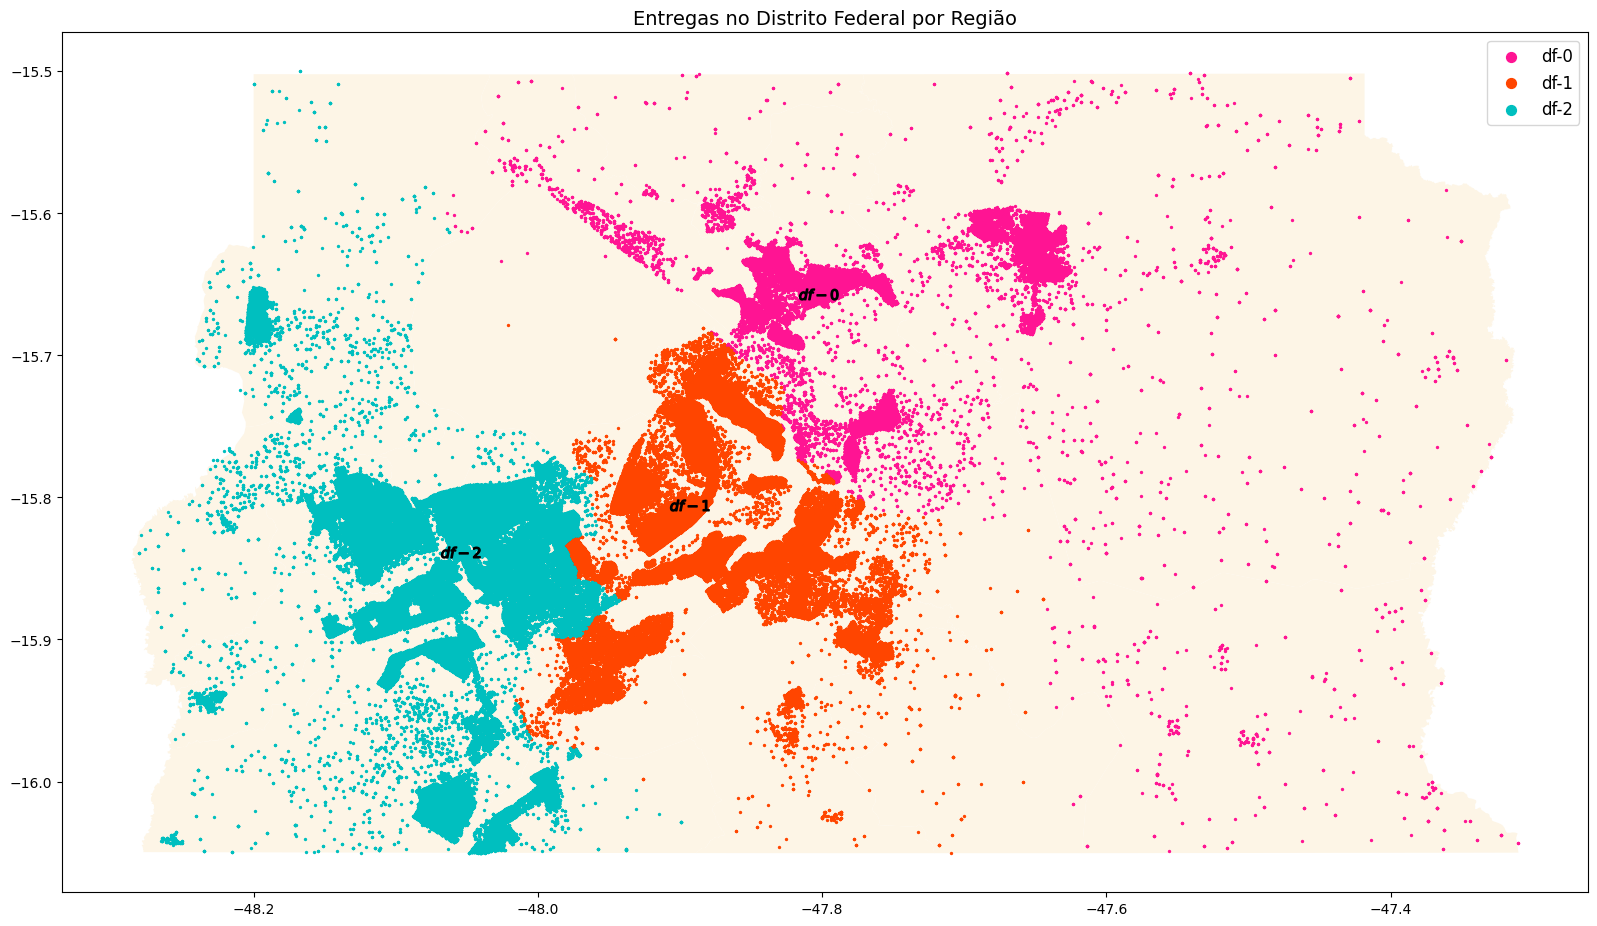

In [32]:
# Criação do mapa
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))
mapa.plot(ax= ax, color= 'oldlace')

# Plot das entregas separadas por região
df_geo_deliveries.query("region == 'df-0'").plot(ax = ax, color= 'deeppink', markersize= 2, label='df-0')
df_geo_deliveries.query("region == 'df-1'").plot(ax = ax, color= 'orangered', markersize= 2, label='df-1')
df_geo_deliveries.query("region == 'df-2'").plot(ax = ax, color= 'c', markersize= 2, label='df-2')

# Plot dos hubs
df_geo_hub.query("region == 'df-0'").plot(ax = ax, marker= '$df-0$', color= 'black', markersize= 800)
df_geo_hub.query("region == 'df-1'").plot(ax = ax, marker= '$df-1$', color= 'black', markersize= 800)
df_geo_hub.query("region == 'df-2'").plot(ax = ax, marker= '$df-2$', color= 'black', markersize= 800)

# Titulos e legendas
plt.title('Entregas no Distrito Federal por Região', fontdict= {'fontsize':14})
lgnd = plt.legend(prop={"size": 12})
for handle in lgnd.legend_handles:
    handle.set_sizes([50])

* **Insights**

1. As entregas estão corretamente alocadas aos seus respectivos hubs;

1. Os hub da região 1 é reponsável por entregas mais concentradas, por se tratar de uma área que possui maior densidade demográfica e por isso as entregas são menos espalhadas nessas regiões;

1. Os hubs das regiões 0 e 2 possuem maior dispersão das entregas, principalmente da região 0, tendo entregas mais distantes e muito espalhadas nas áreas rurais;

### **5.2. Proporção de Entregas por Regiao**

* **Agregação em Porcentagem**

In [33]:
df_proportion = pd.DataFrame(df_deliveries[['region','vehicle_capacity']].value_counts(normalize= True)).reset_index()
df_proportion = df_proportion.drop(columns= 'vehicle_capacity')
df_proportion['proportion'] = df_proportion['proportion'].apply(lambda value: round(value * 100, 2))

* **Visualização**

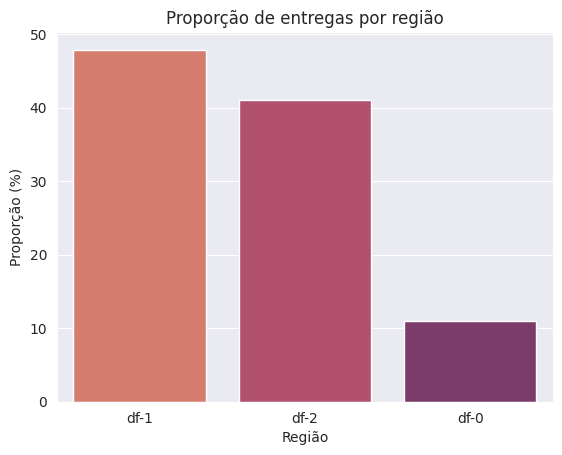

In [34]:
with sns.axes_style('darkgrid'):
    graph1 = sns.barplot(data= df_proportion, x='region', y='proportion', palette= 'flare')
    graph1.set(title= 'Proporção de entregas por região', xlabel= 'Região', ylabel= 'Proporção (%)')

* **Insights**

1. A região 0 representa 10% de todas as entregas, porém mesmo assim possui a mesma capacidade de veículos do demais hubs, porém deve-se levar em consideração que essa região que realiza entregas mais distantes, podendo justificar a capacide de veículos;

1. A região 1 representa quase 50% de todas as entregas, sendo a região com mais entregas a serem feitas, por se tratar também de uma região metropolitana e de alta demanada;

### **5.3. Tamanho das Entregas por Regiao**

* **Separação dos dados**

In [35]:
df_deliveries_sizes = pd.DataFrame(df_deliveries[['region','delivery_size']])
df_deliveries_sizes= df_deliveries_sizes.sort_values('delivery_size', ascending= True).reset_index()

* **Visualização**

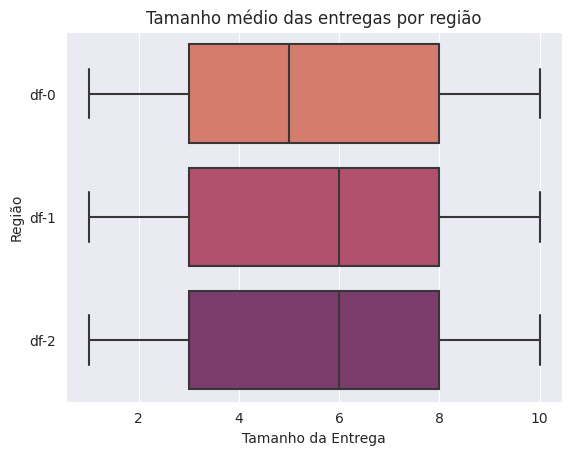

In [36]:
with sns.axes_style('darkgrid'):
    graph2 = sns.boxplot(data= df_deliveries_sizes, x= 'delivery_size', y='region', palette= 'flare')
    graph2.set(title= 'Tamanho médio das entregas por região', xlabel= 'Tamanho da Entrega', ylabel= 'Região')

* **Insights**

1. Todas as regiões possuem distribuição dos tamanhos das entregas relativamente simétricas, sem outliers aparentes

1. A região 0 possui uma mediana ligeiramente abaixo das outras regiões.

Aparentemente não há nenhuma relação relevante entre os tamanhos das entregas com as suas regiões 

### **5.4. Quantidade de entregas por cidade**

* **Agregação**

In [37]:
df_deliveries_cities = pd.DataFrame(df_deliveries['delivery_city'].value_counts())
df_deliveries_cities = df_deliveries_cities.sort_values('count', ascending= False).reset_index()

* **Visualização**

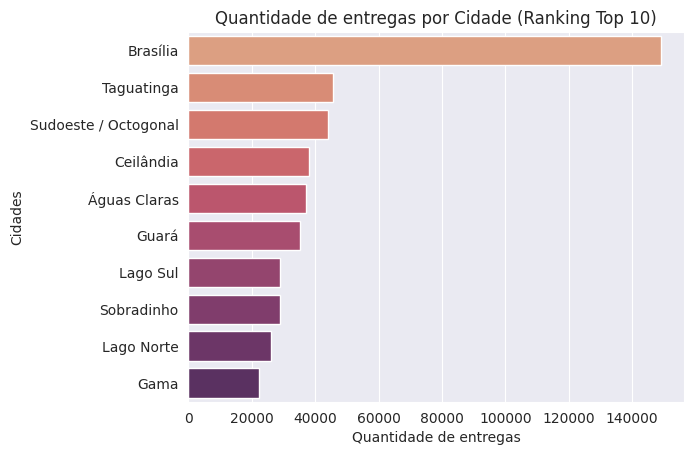

In [38]:
with sns.axes_style('darkgrid'):
    graph3 = sns.barplot(data= df_deliveries_cities.loc[0:9], x= 'count', y= 'delivery_city', palette= 'flare')
    graph3.set(title= 'Quantidade de entregas por Cidade (Ranking Top 10)', xlabel= 'Quantidade de entregas', ylabel= 'Cidades')

* **Insights**

1. A cidade onde há mais entregas é a principal e mais populosa cidade do Distrito, possuindo aproximadamente 15mil entregas somente em Brasília.



### **5.5. Distância das entregas**

* **Ordenação**

In [39]:
df_distance_deliveries = pd.DataFrame(df_deliveries[['distance_hub','region']])
df_distance_deliveries = df_distance_deliveries.sort_values('distance_hub', ascending= True).reset_index()

* **Visualização**

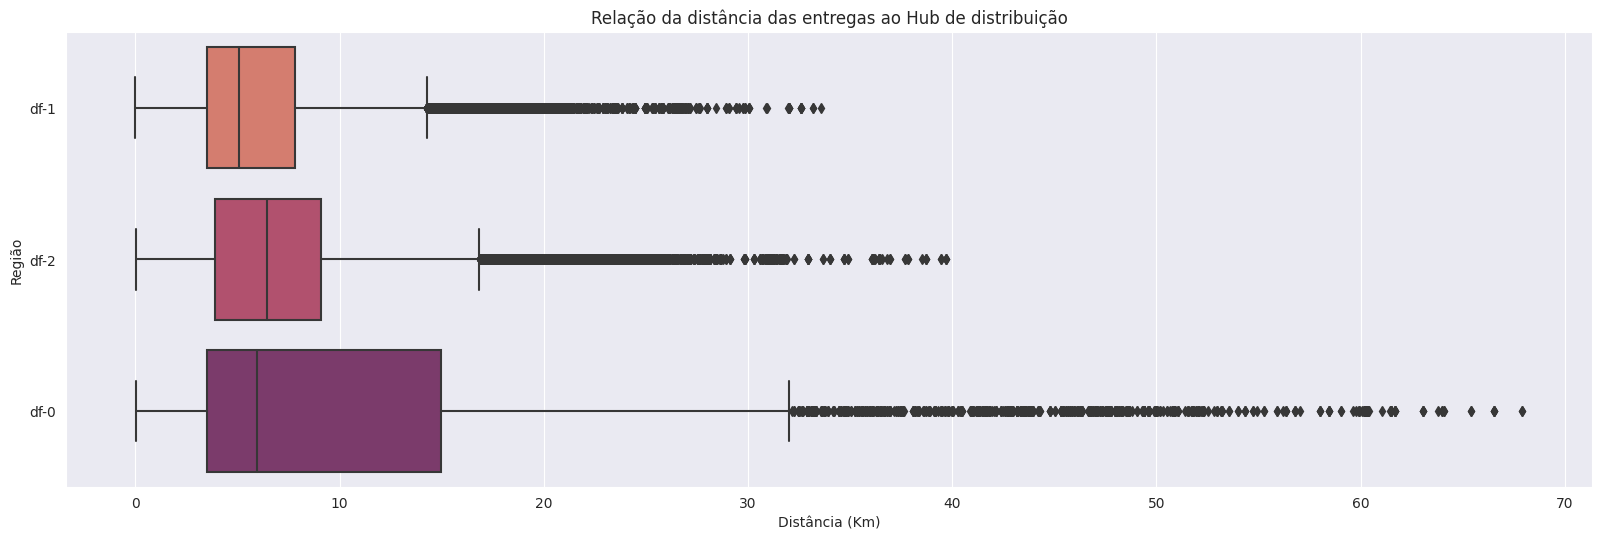

In [40]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize= (50/2.54, 15/2.54))
    graph4 = sns.boxplot(data= df_distance_deliveries, x= 'distance_hub', y= 'region', palette= 'flare', ax = ax)
    graph4.set(title= 'Relação da distância das entregas ao Hub de distribuição', xlabel= 'Distância (Km)', ylabel= 'Região')

* **Insights**

1. A região 0 é a que detêm as entregas mais distantes, possuindo entegas que ultrapassam os 65km, até mesmo as médias das entregas desta região se encontram mais dispersas entre 5km a 15km.

1. A região 1 é a que possui entregas mais concentradas sem muitas dispersões, ficando muito concentrada em entregas próximas ao Hub.

1. A região 2 se encontra em uma relação intermediária com as outras regiões, tendo entregas ligeiramente mais dispersas, porém não tão distantes como a região 0

## 6\. Conclusão

* O HUB df-0 é o que possui a menor quantidade de entregas, representando aproximadamente 10% de todas as entregas do Distrito, porém é o que possui uma maior variação das distância de entregas, possuindo entregas superiores a 65km de distância

* o HUB df-1 está localizado na região central e mais populosa, onde está localizado o maior número de entregas, representando quase 50% de todas as entregas, mesmo possuindo a mesma capacidade das demais regiões. A distância das entregas são mais concentradas.

* o HUB df-2 possui a quantidade de entregas de aproximadamente 40% ficando apenas um pouco abaixo da região 1, com uma variação de distância das entregas chegando com outliers de até 40km.

Em geral nota-se que todos os HUBs possuem a mesma capacidade, mesmo não sendo proporcional a quantidade de entregas. Podendo assim a redistribuição da capacidade de frotas por HUB ser um fator a ser discutido, pois mesmo tendo entregas muito distantes a serem feitas pela região 0, podem ser adotadas rotas de entregas que sejam mais eficientes e que demandem um menor número de frotas, deslocando assim parte dessa frota para as outras duas regiões.

Para consolidação de uma analise mais minunciosa as informações do tempo de cada entrega poderia estar presente na base de dados, podendo assim tirar mais conclusões a respeito das entregas, e assim poder analisar melhor as particularidades de cada entrega.